# Stark Hamiltonian test
## Coupled basis

In [11]:
import numpy as np
import pickle
import sys
import sympy
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib notebook

sys.path.append('../B-state-classes-and-functions/')

from classes import CoupledBasisState, UncoupledBasisState, State
from functions import matrix_to_states, vector_to_state, find_state_idx_from_state, find_closest_state

with open("B_hamiltonians_symbolic_coupled.py",'rb') as f:
    hamiltonians = pickle.load(f)

def ni_range(x0, x1, dx=1):
    # sanity check arguments
    if dx==0:
        raise ValueError("invalid parameters: dx==0")
    if x0>x1 and dx>=0:
        raise ValueError("invalid parameters: x0>x1 and dx>=0")
    if x0<x1 and dx<=0:
        raise ValueError("invalid parameters: x0<x1 and dx<=0")
        
    # generate range list
    range_list = []
    x = x0
    while x < x1:
        range_list.append(x)
        x += dx
    return range_list

#Generate quantum numbers
Jmin = 1
Jmax = 4 # max J value in Hamiltonian
#Jmax = 6
I_Tl = 1/2             # I1 in Ramsey's notation
I_F  = 1/2             # I2 in Ramsey's notation


Omegas = [-1, 1]
# QN = [UncoupledBasisState(J,mJ,I_Tl,m1,I_F,m2, Omega)
#       for J  in ni_range(Jmin, Jmax+1)
#       for Omega in Omegas
#       for mJ in ni_range(-J,J+1)
#       for m1 in ni_range(-I_Tl,I_Tl+1)
#       for m2 in ni_range(-I_F,I_F+1)
#      ]

Omegas = [-1,1]
QN_c = [CoupledBasisState(F,mF,F1,J,I_F,I_Tl, Omega)
      for J  in ni_range(Jmin, Jmax+1)
      for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
      for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
      for mF in ni_range(-F,F+1)
      for Omega in Omegas
     ]

In [12]:
variables = [
    *sympy.symbols('Brot Drot H_const'),
    *sympy.symbols('h1_Tl h1_F'),
    sympy.symbols('q'),
    sympy.symbols('c_Tl'),
    sympy.symbols('c1p_Tl'),
    sympy.symbols('D_TlF'),
    sympy.symbols('mu_B'),
    *sympy.symbols('gS gL')
]

lambdified_hamiltonians = {
    H_name : sympy.lambdify(variables, H_matrix)
    for H_name, H_matrix in hamiltonians.items()
}

Insert the numerical constants:

In [14]:
#Constants in Hz
Brot = 6687.879e6
Drot = 0.010869e6
H_const = -8.1e-2
h1_Tl = 28789e6
h1_F = 861e6
q = 2.423e6
c_Tl = -7.83e6
c1p_Tl = 11.17e6
D_TlF = 2.28 * 0.393430307 *5.291772e-9/4.135667e-15 # [Hz/(V/cm)]
mu_B = 2e6 #Hz/G
gL = 1
gS = 2


H = {
    H_name : H_fn(
        Brot, Drot, H_const,
        h1_Tl, h1_F,
        q,
        c_Tl,
        c1p_Tl,
        D_TlF,
        mu_B,
        gS, gL
    )
    for H_name, H_fn in lambdified_hamiltonians.items()
}



In [15]:
#Check that hamiltonian is hermitian
H_test = H["Hrot"]+H["H_mhf_Tl"]+H["H_mhf_F"]+H["H_c_Tl"]+H["H_LD"]+H["H_cp1_Tl"]+H["HSx"]+H["HSy"]+H["HSz"]+H["HZz"]
print(np.allclose(H_test, H_test.conj().T))

True


In [16]:
#Loop over electric field values and diagonalize hamiltonian
Ezs = np.linspace(0,300,300)
energies_c = np.zeros((len(Ezs), H_test.shape[0]))
evecs_c = np.zeros((len(Ezs), H_test.shape[0], H_test.shape[1]))


for i, Ez in enumerate(tqdm(Ezs)):
    H_i = H["Hrot"]+H["H_mhf_Tl"]+H["H_mhf_F"]+H["H_c_Tl"]+H["H_LD"]+H["H_cp1_Tl"]+Ez*H["HSz"]+0.001*H["HZz"]
    
    D,V = np.linalg.eigh(H_i)
    energies_c[i,:] = D
    evecs_c[i,:,:] = V

<IPython.core.display.Javascript object>


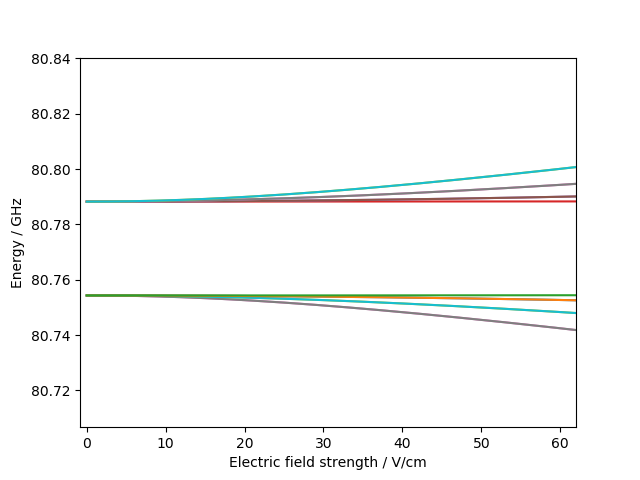

Text(0, 0.5, 'Energy / GHz')

In [17]:
fig, ax = plt.subplots()

for i in range(0, 192):
    ax.plot(Ezs,energies_c[:,i]/1e9)

ax.set_xlabel("Electric field strength / V/cm")
ax.set_ylabel("Energy / GHz")

## Uncoupled basis

In [18]:
with open("B_hamiltonians_symbolic_St.py",'rb') as f:
    hamiltonians = pickle.load(f)

#Generate quantum numbers
Jmin = 1
Jmax = 4 # max J value in Hamiltonian
#Jmax = 6
I_Tl = 1/2             # I1 in Ramsey's notation
I_F  = 1/2             # I2 in Ramsey's notation


Omegas = [-1, 1]
QN = [UncoupledBasisState(J,mJ,I_Tl,m1,I_F,m2, Omega)
      for J  in ni_range(Jmin, Jmax+1)
      for Omega in Omegas
      for mJ in ni_range(-J,J+1)
      for m1 in ni_range(-I_Tl,I_Tl+1)
      for m2 in ni_range(-I_F,I_F+1)
     ]

# QN = []
# for Omega in Omegas:
#     for J in np.arange(Jmin, Jmax+1):
#         for m1 in np.arange(-I_Tl,I_Tl+1):
#             for m2 in np.arange(-I_F,I_F+1):
#                 mJ = 0-m1-m2

#                 if np.abs(mJ) <= J:
#                     QN.append(UncoupledBasisState(J,mJ,I_Tl,m1,I_F,m2, Omega))


In [19]:
variables = [
    *sympy.symbols('Brot Drot H_const'),
    *sympy.symbols('h1_Tl h1_F'),
    sympy.symbols('q'),
    sympy.symbols('c1'),
    sympy.symbols('c_Tl_p'),
    *sympy.symbols('gL gS'),
    sympy.symbols('D_TlF')
]

lambdified_hamiltonians = {
    H_name : sympy.lambdify(variables, H_matrix)
    for H_name, H_matrix in hamiltonians.items()
}

Insert the numerical constants:

In [20]:
#Constants in MHz
Brot = 6687.879e6
Drot = 0.010869e6
H_const = -8.1e-2
h1_Tl = 28789e6
h1_F = 861e6
q = 2.423e6
c1 = -7.83e6
c_Tl_p = 11.17e6
gL = 1
gS = 2
D_TlF = 2.28 * 0.393430307 *5.291772e-9/4.135667e-15 # [Hz/(V/cm)]


H = {
    H_name : H_fn(
        Brot, Drot, H_const,
        h1_Tl, h1_F,
        q,
        c1,
        c_Tl_p,
        gL, gS,
        D_TlF
    )
    for H_name, H_fn in lambdified_hamiltonians.items()
}



Check that Hamiltonian is hermitian and diagonalize the Hamiltonian

In [21]:
H_test = H["Hrot"]+H["H_mhf_Tl"]+H["H_mhf_F"]+H["Hc1"]+H["H_LD"]+H["H_c1_p"]+H["HSx"]+H["HSy"]+H["HSz"]
print(np.allclose(H_test, H_test.conj().T))

True


In [22]:
#Loop over electric field values and diagonalize hamiltonian
Ezs = np.linspace(0,300,300)
energies = np.zeros((len(Ezs), H_test.shape[0]))
evecs = np.zeros((len(Ezs), H_test.shape[0], H_test.shape[1]))


for i, Ez in enumerate(tqdm(Ezs)):
    H_i = H["Hrot"]+H["H_mhf_Tl"]+H["H_mhf_F"]+H["Hc1"]+H["H_LD"]+H["H_c1_p"]+Ez*H["HSz"]
    
    D,V = np.linalg.eigh(H_i)
    energies[i,:] = D
    evecs[i,:,:] = V

<IPython.core.display.Javascript object>


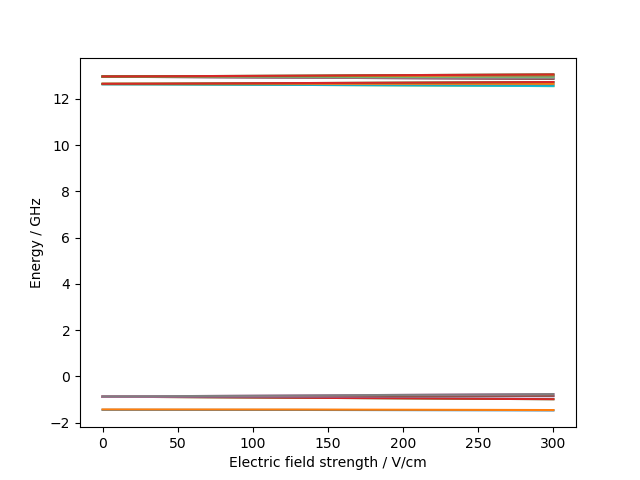

Text(0, 0.5, 'Energy / GHz')

In [23]:
fig, ax = plt.subplots()

for i in range(0, 24):
    ax.plot(Ezs,energies[:,i]/1e9)

ax.set_xlabel("Electric field strength / V/cm")
ax.set_ylabel("Energy / GHz")

In [24]:
#Check if the energies are the same
np.allclose(energies_c,energies)

True

## Eigenstates
Looking at the eigenstates at various electric fields

In [25]:
#Print the J = 1 states at E = 0
for i in range(0, 24):
    print("\n|{:d}> = ".format(i))
    vector_to_state(evecs_c[0,:,i], QN_c).print_state()


|0> = 
-0.7071+0.0000j x |J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, Omega = -1, P = None>
+0.7071+0.0000j x |J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, Omega = 1, P = None>

|1> = 
+0.7071+0.0000j x |J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, Omega = -1, P = None>
+0.7071+0.0000j x |J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, Omega = 1, P = None>

|2> = 
-0.7069+0.0000j x |J = 1, F1 = 1/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, Omega = -1, P = None>
+0.7069+0.0000j x |J = 1, F1 = 1/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, Omega = 1, P = None>

|3> = 
+0.7069+0.0000j x |J = 1, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, Omega = -1, P = None>
-0.7069+0.0000j x |J = 1, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, Omega = 1, P = None>

|4> = 
+0.7069+0.0000j x |J = 1, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, Omega = -1, P = None>
-0.7069+0.0000j x |J = 1, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, Omega = 1, P = None>

|5> = 
-0.7069+0.0000j x |J = 1,

In [26]:
#Print the J = 1 states at E = Emax
for i in range(0, 24):
    print("\n|{:d}> = ".format(i))
    vector_to_state(evecs_c[-1,:,i], QN_c).print_state()


|0> = 
-0.6937+0.0000j x |J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, Omega = -1, P = None>
+0.6937+0.0000j x |J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, Omega = 1, P = None>
+0.1365+0.0000j x |J = 1, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, Omega = -1, P = None>
+0.1365+0.0000j x |J = 1, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, Omega = 1, P = None>

|1> = 
+0.6923+0.0000j x |J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, Omega = -1, P = None>
+0.6923+0.0000j x |J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, Omega = 1, P = None>
-0.1435+0.0000j x |J = 1, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, Omega = -1, P = None>
+0.1436+0.0000j x |J = 1, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, Omega = 1, P = None>

|2> = 
+0.9991+0.0000j x |J = 1, F1 = 1/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, Omega = -1, P = None>

|3> = 
+0.9991+0.0000j x |J = 1, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, Omega = 1, P = None>

|4> = 
-0.1438+0.0000j x |J = 1, F1 = 1/2